In [7]:
import datetime
import matplotlib.pyplot as plt
import numpy as np

from numpy import linalg
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

import gaii_cond_linear
import var
import visualize

In [8]:
def plot_divergence(result, datadir, N):
    x = [t["x"] for t in result]
    js = [t["js"] for t in result]
    mi = [t["mi"] for t in result]

    fig = plt.figure()
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(x, js, label="JS")
    ax1.legend()
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(x, mi, label="MI")
    ax2.legend()
    plt.savefig(datadir.joinpath("N={}／divergence.png".format(N)))
    plt.close('all')

def plot_state_list(state_list, datadir):
    plt.figure()
    plt.plot(state_list[:, 0])
    plt.savefig(datadir.joinpath("state_list.png"))
    plt.close('all')

def experiment_gaiit(N, datadir, target, mask, noise="low"):
    result=[]
    variants = np.arange(0.05, 0.4, 0.05)
    for x in tqdm(variants):
        localdir = datadir.joinpath("N={N}／target={target}／x={x:.3f}／mask={mask}".format(**locals()))
        localdir.mkdir(parents=True, exist_ok=True)
        if target == "diag":
            A_true = np.eye(N,N) * x + np.eye(N,N,k=1) * 0.05
        elif target == "no_diag":
            A_true = np.eye(N,N) * 0.05 + np.eye(N,N,k=1) * x
        else:
            assert "ここには入らない"
        if noise == "low":
            Sigma_true = np.eye(N,N) * 0.03 + np.eye(N,N,k=1) * 0.03
        else:
            L = np.eye(N,N) * 1 + np.eye(N,N,k=1) * 0.7
            Sigma_true = L @ L.T

        initiali_state = np.random.multivariate_normal([0] * N, np.eye(N,N) * 0.1, size=1)[0]
        state_list = var.generate(initiali_state, A_true, Sigma_true, N=10000)
        plot_state_list(state_list, localdir)

        mi = 1/2 * np.log(linalg.det(np.cov(state_list.T)) / linalg.det(Sigma_true))
        if mask == "eye":
            mask_q = np.eye(N, N)
        elif mask == "none":
            mask_q = np.ones((N, N))
        else:
            assert "NG"
        model_q = gaii_cond_linear.fit_q(state_list, mask_q, n_step=10000)
        js = model_q["js"]

        with localdir.joinpath("log.txt").open("w") as f:
            f.write("A\n" + str(A_true) + "\n\n")
            f.write("det A\n" + str(linalg.det(A_true)) + "\n\n")
            f.write("SigmaE\n" + str(Sigma_true) + "\n\n")
            f.write("det SigmaE\n" + str(linalg.det(Sigma_true)) + "\n\n")
            f.write("Phi_mi" + str(mi) + "\n")
            f.write("Phi_js" + str(js) + "\n")

        visualize.imshow(model_q, localdir)
        visualize.failure_check(model_q, localdir)
        visualize.mode_check(model_q, localdir)
        result.append({
            "x": x,
            "js": js,
            "mi": mi
        })
    plot_divergence(result, datadir, N)



In [11]:
now = datetime.datetime.now()
datadir = Path("../data") / "exp_gaii_div" / now.strftime('%Y%m%d-%H%M%S')
datadir.mkdir(parents=True, exist_ok=True)

for N in [2, 4, 8, 16, 32]:
    experiment_gaiit(N=N, datadir=datadir, target="no_diag", mask="eye", noise="low")

  0%|          | 0/7 [00:00<?, ?it/s]

/Users/sasano/gaii/src/var.py:11: RuntimeWarning: covariance is not positive-semidefinite.
  E = np.random.multivariate_normal(
[E thread_pool.cpp:112] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [29]:
import torch
x = torch.randn(2, 3)
x

tensor([[ 0.1524, -0.5824, -0.6356],
        [-0.7590, -0.7316,  2.4858]])

In [32]:
x[:, [[0,1], [1,2]]]

tensor([[[ 0.1524, -0.5824],
         [-0.5824, -0.6356]],

        [[-0.7590, -0.7316],
         [-0.7316,  2.4858]]])

In [37]:
np.arange((1,3), (3,5))

TypeError: arange: scalar arguments expected instead of a tuple.

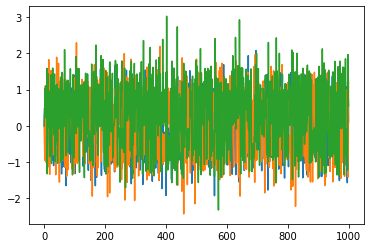

In [16]:
import test_data
import importlib
importlib.reload(test_data)
import matplotlib.pyplot as plt
data = test_data.nonlinear_var3()

plt.plot(data)